<a href="https://colab.research.google.com/github/iampatgrady/Colaboratory-Analytics-Demos/blob/master/Automated_Reporting_Using_FB_Prophet_%2B_GA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example using FB Prophet to detect Anomalous Campaign Behavior
We're going to create a time seres for the CPL ('cost per lead')  metric per each campaign.  
We forecast into the future using [FB Prophet](https://facebook.github.io/prophet/) to then evaluate new data against it.

Solve for:
```
... working on building automated reports that tell when a campaign has seen a significant change in performance... The question is what is the best way to determine when a CPL has increased enough to be concerned?
```

## Setup Notebook

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from fbprophet import Prophet

pd.options.mode.chained_assignment = None # fix this

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive

## Define Holidays

In [0]:
# Define Holidays
holidays = pd.DataFrame({
  'holiday': 'Christmas',
  'ds': pd.to_datetime(['2016-12-25', '2017-12-25', '2018-12-25', '2019-12-25']),
  'lower_window': -7,
  'upper_window': 3,
})

holidays = holidays.append(pd.DataFrame({
  'holiday': 'Black Friday',
  'ds': pd.to_datetime(['2016-11-25', '2017-11-24', '2018-11-23', '2019-11-29']),
  'lower_window': 0,
  'upper_window': 0,
}))

holidays = holidays.append(pd.DataFrame({
  'holiday': 'Cyber Monday',
  'ds': pd.to_datetime(['2016-11-28', '2017-11-27', '2018-11-26', '2019-12-02']),
  'lower_window': 0,
  'upper_window': 0,
}))

## getForecast Utility Function

In [0]:
def getForecast(m,d,x=30):
  m.fit(d)
  # Make a prediction x days into the future
  f = m.make_future_dataframe(x)
  return m.predict(f)

## Load CSV from Drive
This step presumes you have:

*   [Downloaded my example](https://storage.googleapis.com/pats-test/Google%20Merch%20Store.csv)  OR
*  Visit https://analytics.google.com/analytics/web/demoAccount
 *  Created a custom report in GA 
 *  Use Date and Campaign dimensions
 *  Use Revenue, Cost, and New Users metrics
 * Capture as much time as possible
 *  Export report to Sheets 
*  Upload CSV to Drive 





In [4]:
df = pd.read_csv('Google Merch Store.csv',skiprows=6)
df['Date'] = pd.to_datetime(df.Date, format="%Y%m%d")
df.head()

,Campaign,Date,Revenue,Cost,New Users
0,AW - Accessories,2016-05-10,2483.88,5.29,44
1,AW - Dynamic Search Ads Whole Site,2017-10-27,2245.93,30.52,45
2,AW - Dynamic Search Ads Whole Site,2016-12-07,2148.27,31.29,91
3,AW - Office,2018-09-21,1921.94,1.87,12
4,AW - Apparel,2018-08-24,1623.75,4.26,8


## Example Time Series Analysis

### Grab first campaign, process


*   Create custom metric,  `'CPL' = Cost  /  New Users`
*   Pivot on Date, Sum the CPL
*   Rename columns to match FB Prophet syntax: `Date: ds, CPL: y`



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning:

invalid value encountered in true_divide



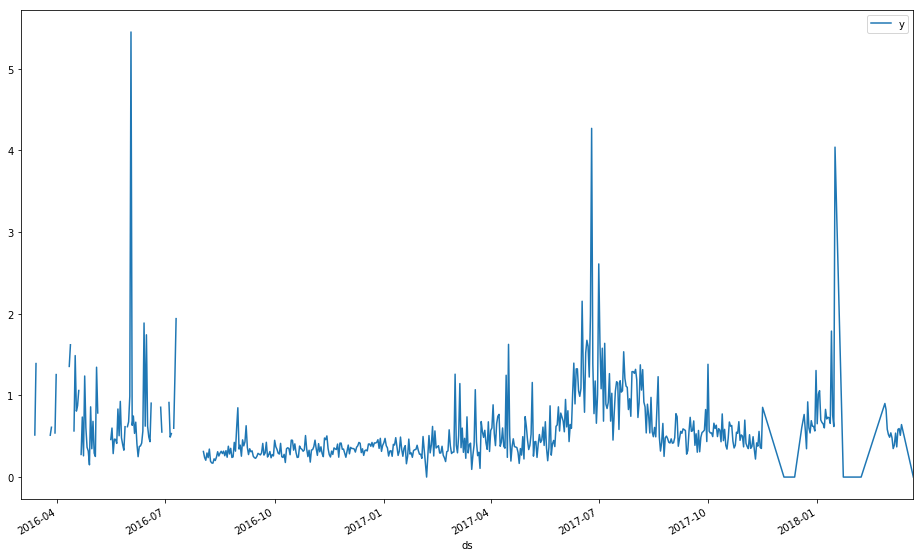

In [5]:
#isolate the first campaign
first_campaign_df = df.loc[df.Campaign == 'AW - Dynamic Search Ads Whole Site']

#create a custom metric  'Cost per Lead',  cost / new users
first_campaign_df['CPL'] = np.divide(first_campaign_df.Cost, first_campaign_df['New Users'],)

#format FB Prophet data frame,  date = ds,  metric = y
input = first_campaign_df.groupby('Date').agg({'CPL': 'sum'}).sort_values('Date').reset_index().rename(columns={'Date': 'ds', 'CPL': 'y'})

#plot input data frame
_ = input.plot(x='ds',figsize=(16,10))

### Calculate 7-day rolling average
Use STD() and MEAN()


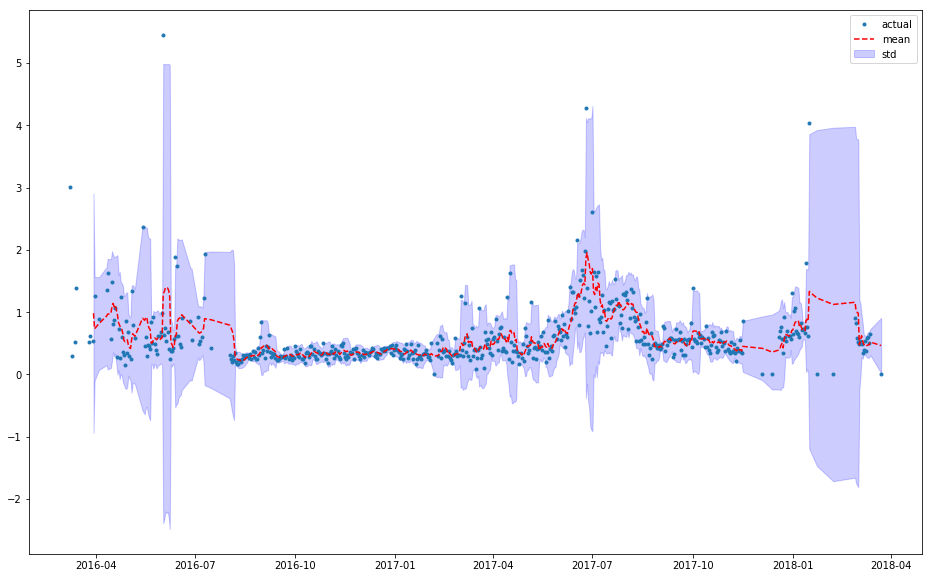

In [6]:
# fix the infinity values
input = input[~input.isin([np.nan, np.inf, -np.inf]).any(1)]

# calculate 7-day rolling average for mean() and std()
ma = input.rolling(7, on='ds').mean()
mstd = input.rolling(7, on='ds').std()

#plot output
plt.figure(figsize=(16,10))
plt.plot(input.ds, input.y, '.',label='actual')
plt.plot(ma.ds, ma.y, '--r', label='mean')
plt.fill_between(mstd.ds, ma.y - 2 * mstd.y, ma.y + 2 * mstd.y,color='b', alpha=0.2, label='std')
plt.legend()
plt.show()

### Build a forecast for the campaign

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


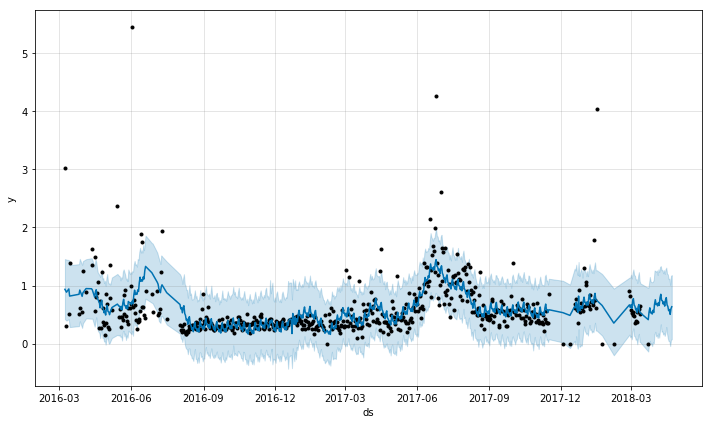

In [7]:
# init Prophet object, enable Monte Carlo Markov Chain to improve accuracy
m = Prophet(holidays=holidays, mcmc_samples=100)
forecast = getForecast(m, input,30)

# Plot the model and forecast with additional trend analysis
from fbprophet.plot import add_changepoints_to_plot
_ = m.plot(forecast)

### Inspect the model components
To make predictions, you take the input and add the relevant weights. There is a `trend` over time, a `holidays`  modifier, and interval seasonal patterns. All those weights added together equals the prediction for new data. In this case, an input value in June on a Saturday would get a major boost from the `weekly` and `yearly` models.

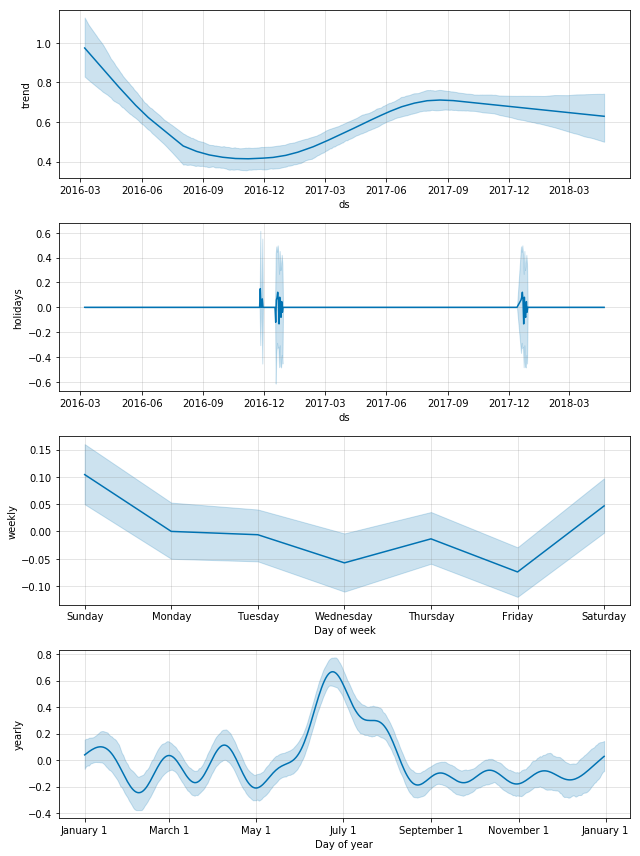

In [8]:
_ = m.plot_components(forecast)

### Filter outliers
We want to identify the values that fell outside of the upper and lower prediction boundaries. We'll graph those outliers in red below.

In [9]:
combine = pd.concat([input.y,forecast],axis=1,sort='ds')
filter = combine.loc[(combine.y > combine.yhat_upper) | (combine.y < combine.yhat_lower)][['ds','y']]
filter.head() # list of outliers

,ds,y
7,2016-03-31,3.0150
9,2016-04-11,0.2975
28,2016-05-03,1.2550
39,2016-05-22,1.3550
40,2016-05-23,1.6200


### Plot outliers, forecast, and rolling average

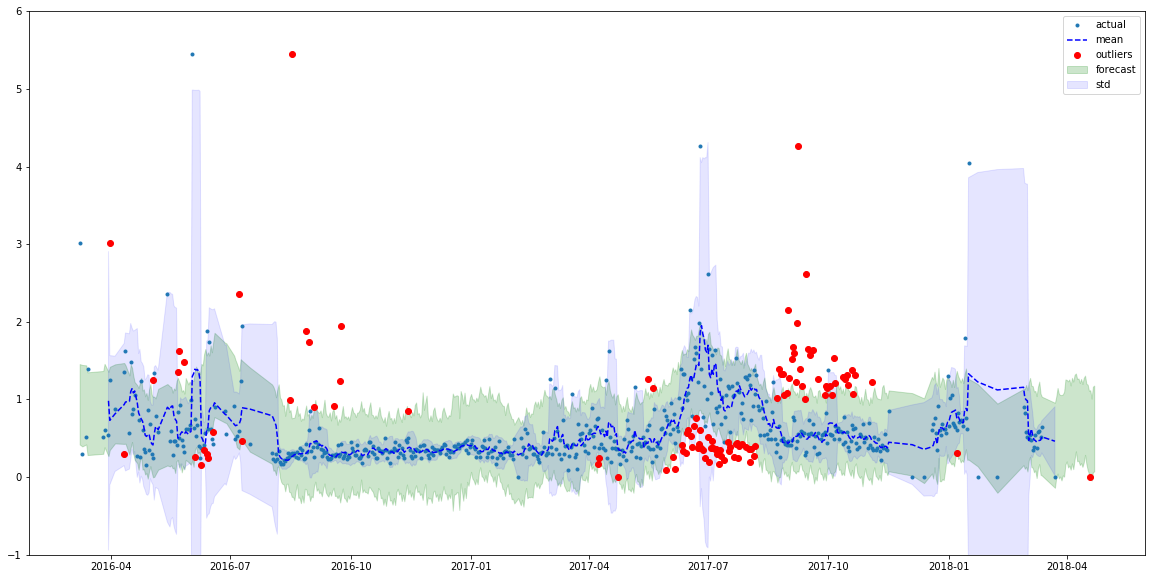

In [10]:
plt.figure(figsize=(20,10))
plt.axes(ylim=(-1,6))

# plot the actuals
plt.plot(input.ds, input.y, '.', label='actual')

# plot the rolling average mean 
plt.plot(ma.ds, ma.y, '--b', label='mean')

# plot the Prophet model forecast boundaries
plt.fill_between(combine.ds, combine.yhat_lower, combine.yhat_upper,color='g', alpha=0.2, label='forecast')

# plot the rolling-average
plt.fill_between(mstd.ds, ma.y - 2 * mstd.y, ma.y + 2 * mstd.y,color='b', alpha=0.1, label='std')

# plot the outliers 
plt.plot(filter.ds, filter.y,'o',c='r', label='outliers')


plt.legend()
plt.show()

## Next Steps


*   Fix `CPL` to be your desired metric
*   Loop through all campaigns, model and build forecast
*   Fine tune `holidays` object to meet your needs
*   Save forecasts to BigQuery or Google Sheets
*   Evaluate new data against your forecasts
*   Replace Google Sheets with BigQuery query

